
# CSTR Continuously Stirred Tank Reactor

http://apmonitor.com/do/index.php/Main/NonlinearControl 
dort:
Solution in Python
PID for CSTR Control (Python) - Solution Video

https://www.extrica.com/article/20447 

http://engineering.nyu.edu/mechatronics/Control_Lab/Criag/Craig_RPI/2002/Week2/First-Order_Process_Time_Delay_2002.pdf 


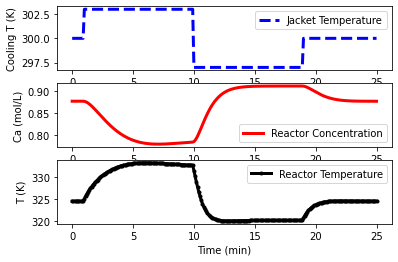

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# define CSTR model
def cstr(x,t,u,Tf,Caf):
    # Inputs (3):
    # Temperature of cooling jacket (K)
    Tc = u
    # Tf = Feed Temperature (K)
    # Caf = Feed Concentration (mol/m^3)

    # States (2):
    # Concentration of A in CSTR (mol/m^3)
    Ca = x[0]
    # Temperature in CSTR (K)
    T = x[1]

    # Parameters:
    # Volumetric Flowrate (m^3/sec)
    q = 100
    # Volume of CSTR (m^3)
    V = 100
    # Density of A-B Mixture (kg/m^3)
    rho = 1000
    # Heat capacity of A-B Mixture (J/kg-K)
    Cp = 0.239
    # Heat of reaction for A->B (J/mol)
    mdelH = 5e4
    # E - Activation energy in the Arrhenius Equation (J/mol)
    # R - Universal Gas Constant = 8.31451 J/mol-K
    EoverR = 8750
    # Pre-exponential factor (1/sec)
    k0 = 7.2e10
    # U - Overall Heat Transfer Coefficient (W/m^2-K)
    # A - Area - this value is specific for the U calculation (m^2)
    UA = 5e4
    # reaction rate
    rA = k0*np.exp(-EoverR/T)*Ca

    # Calculate concentration derivative
    dCadt = q/V*(Caf - Ca) - rA
    # Calculate temperature derivative
    dTdt = q/V*(Tf - T) \
            + mdelH/(rho*Cp)*rA \
            + UA/V/rho/Cp*(Tc-T)
    
    # Return xdot:
    xdot = np.zeros(2)
    xdot[0] = dCadt
    xdot[1] = dTdt
    return xdot

# Steady State Initial Conditions for the States
Ca_ss = 0.87725294608097
T_ss = 324.475443431599
x0 = np.empty(2)
x0[0] = Ca_ss
x0[1] = T_ss

# Steady State Initial Condition
u_ss = 300.0
# Feed Temperature (K)
Tf = 350
# Feed Concentration (mol/m^3)
Caf = 1

# Time Interval (min)
t = np.linspace(0,25,251)

# Store results for plotting
Ca = np.ones(len(t)) * Ca_ss
T = np.ones(len(t)) * T_ss
u = np.ones(len(t)) * u_ss

# Step cooling temperature to 295
u[10:100] = 303.0
u[100:190] = 297.0
u[190:] = 300.0

# Simulate CSTR
for i in range(len(t)-1):
    ts = [t[i],t[i+1]]
    y = odeint(cstr,x0,ts,args=(u[i+1],Tf,Caf))
    Ca[i+1] = y[-1][0]
    T[i+1] = y[-1][1]
    x0[0] = Ca[i+1]
    x0[1] = T[i+1]

# Construct results and save data file
# Column 1 = time
# Column 2 = cooling temperature
# Column 3 = reactor temperature
data = np.vstack((t,u,T)) # vertical stack
data = data.T             # transpose data
np.savetxt('data_doublet.txt',data,delimiter=',')
    
# Plot the results
plt.figure()
plt.subplot(3,1,1)
plt.plot(t,u,'b--',linewidth=3)
plt.ylabel('Cooling T (K)')
plt.legend(['Jacket Temperature'],loc='best')

plt.subplot(3,1,2)
plt.plot(t,Ca,'r-',linewidth=3)
plt.ylabel('Ca (mol/L)')
plt.legend(['Reactor Concentration'],loc='best')

plt.subplot(3,1,3)
plt.plot(t,T,'k.-',linewidth=3)
plt.ylabel('T (K)')
plt.xlabel('Time (min)')
plt.legend(['Reactor Temperature'],loc='best')

plt.show()


Initial SSE Objective: 1803.5188706180043


c:\Users\eusch\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Final SSE Objective: 588.7784615139777
Kp: 2.1446210278423794
taup: 0.884262810126362
thetap: 1.1487864935061918e-22


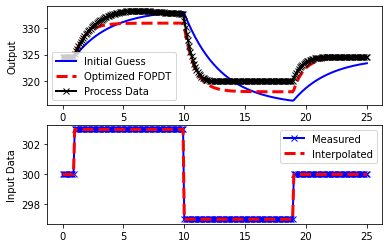

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# Import CSV data file
# Column 1 = time (t)
# Column 2 = input (u)
# Column 3 = output (yp)
data = np.loadtxt('data_doublet.txt',delimiter=',')
u0 = data[0,1]
yp0 = data[0,2]
t = data[:,0].T
u = data[:,1].T
yp = data[:,2].T

# specify number of steps
ns = len(t)
delta_t = t[1]-t[0]
# create linear interpolation of the u data versus time
uf = interp1d(t,u)

# define first-order plus dead-time approximation    
def fopdt(y,t,uf,Km,taum,thetam):
    # arguments
    #  y      = output
    #  t      = time
    #  uf     = input linear function (for time shift)
    #  Km     = model gain
    #  taum   = model time constant
    #  thetam = model time constant
    # time-shift u
    try:
        if (t-thetam) <= 0:
            um = uf(0.0)
        else:
            um = uf(t-thetam)
    except:
        #print('Error with time extrapolation: ' + str(t))
        um = u0
    # calculate derivative
    dydt = (-(y-yp0) + Km * (um-u0))/taum
    return dydt

# simulate FOPDT model with x=[Km,taum,thetam]
def sim_model(x):
    # input arguments
    Km = x[0]
    taum = x[1]
    thetam = x[2]
    # storage for model values
    ym = np.zeros(ns)  # model
    # initial condition
    ym[0] = yp0
    # loop through time steps    
    for i in range(0,ns-1):
        ts = [delta_t*i,delta_t*(i+1)]
        y1 = odeint(fopdt,ym[i],ts,args=(uf,Km,taum,thetam))
        ym[i+1] = y1[-1]
    return ym

# define objective
def objective(x):
    # simulate model
    ym = sim_model(x)
    # calculate objective
    obj = 0.0
    for i in range(len(ym)):
        obj = obj + (ym[i]-yp[i])**2    
    # return result
    return obj

# initial guesses
x0 = np.zeros(3)
x0[0] = 3.0 # Km
x0[1] = 3.0 # taum
x0[2] = 0.0 # thetam

# show initial objective
print('Initial SSE Objective: ' + str(objective(x0)))

# optimize Km, taum, thetam
# bounds on variables
bnds = ((-1.0e10, 1.0e10), (0.01, 1.0e10), (0.0, 5.0))
solution = minimize(objective,x0,method='SLSQP',bounds=bnds)
x = solution.x

# show final objective
print('Final SSE Objective: ' + str(objective(x)))

print('Kp: ' + str(x[0]))
print('taup: ' + str(x[1]))
print('thetap: ' + str(x[2]))

# calculate model with updated parameters
ym1 = sim_model(x0)
ym2 = sim_model(x)
# plot results
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,ym1,'b-',linewidth=2,label='Initial Guess')
plt.plot(t,ym2,'r--',linewidth=3,label='Optimized FOPDT')
plt.plot(t,yp,'kx-',linewidth=2,label='Process Data')
plt.ylabel('Output')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(t,u,'bx-',linewidth=2)
plt.plot(t,uf(t),'r--',linewidth=3)
plt.legend(['Measured','Interpolated'],loc='best')
plt.ylabel('Input Data')
plt.show()


In [3]:
# from identification
Kp = 2.16288502017
taup = 0.913444964569
thetap = 0.000121628824381

# design PI controller
tauc = max(0.1*taup,0.8*thetap)
Kc = (1.0/Kp)*(taup/(thetap+tauc))
tauI = taup

print('Kc: ' + str(Kc))
print('tauI: ' + str(tauI))


Kc: 4.617306151813776
tauI: 0.913444964569


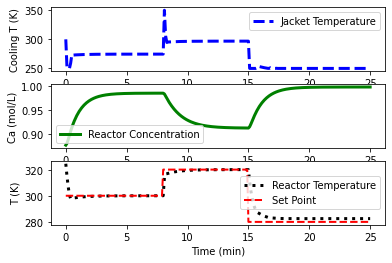

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# from IMC tuning
Kc = 4.61730615181
tauI = 0.913444964569
tauD = 0.0

# define CSTR model
def cstr(x,t,u,Tf,Caf):
    # Inputs (3):
    # Temperature of cooling jacket (K)
    Tc = u
    # Tf = Feed Temperature (K)
    # Caf = Feed Concentration (mol/m^3)

    # States (2):
    # Concentration of A in CSTR (mol/m^3)
    Ca = x[0]
    # Temperature in CSTR (K)
    T = x[1]

    # Parameters:
    # Volumetric Flowrate (m^3/sec)
    q = 100
    # Volume of CSTR (m^3)
    V = 100
    # Density of A-B Mixture (kg/m^3)
    rho = 1000
    # Heat capacity of A-B Mixture (J/kg-K)
    Cp = 0.239
    # Heat of reaction for A->B (J/mol)
    mdelH = 5e4
    # E - Activation energy in the Arrhenius Equation (J/mol)
    # R - Universal Gas Constant = 8.31451 J/mol-K
    EoverR = 8750
    # Pre-exponential factor (1/sec)
    k0 = 7.2e10
    # U - Overall Heat Transfer Coefficient (W/m^2-K)
    # A - Area - this value is specific for the U calculation (m^2)
    UA = 5e4
    # reaction rate
    rA = k0*np.exp(-EoverR/T)*Ca

    # Calculate concentration derivative
    dCadt = q/V*(Caf - Ca) - rA
    # Calculate temperature derivative
    dTdt = q/V*(Tf - T) \
            + mdelH/(rho*Cp)*rA \
            + UA/V/rho/Cp*(Tc-T)
    
    # Return xdot:
    xdot = np.zeros(2)
    xdot[0] = dCadt
    xdot[1] = dTdt
    return xdot

# Steady State Initial Conditions for the States
Ca_ss = 0.87725294608097
T_ss = 324.475443431599
x0 = np.empty(2)
x0[0] = Ca_ss
x0[1] = T_ss

# Steady State Initial Condition
u_ss = 300.0
# Feed Temperature (K)
Tf = 350
# Feed Concentration (mol/m^3)
Caf = 1

# Time Interval (min)
t = np.linspace(0,25,251)

# Store results for plotting
Ca = np.ones(len(t)) * Ca_ss
T = np.ones(len(t)) * T_ss
u = np.ones(len(t)) * u_ss


# storage for recording values
op = np.zeros(len(t))  # controller output
pv = np.zeros(len(t))  # process variable
e = np.zeros(len(t))   # error
ie = np.zeros(len(t))  # integral of the error
dpv = np.zeros(len(t)) # derivative of the pv
P = np.zeros(len(t))   # proportional
I = np.zeros(len(t))   # integral
D = np.zeros(len(t))   # derivative
sp = np.zeros(len(t))  # set point
sp[0:80] = 300.0
sp[80:150] = 320.0
sp[150:] = 280.0

# Upper and Lower limits on OP
op_hi = 350.0
op_lo = 250.0

pv[0] = T_ss
# loop through time steps    
for i in range(len(t)-1):
    delta_t = t[i+1]-t[i]
    e[i] = sp[i] - pv[i]
    if i >= 1:  # calculate starting on second cycle
        dpv[i] = (pv[i]-pv[i-1])/delta_t
        ie[i] = ie[i-1] + e[i] * delta_t
    P[i] = Kc * e[i]
    I[i] = Kc/tauI * ie[i]
    D[i] = - Kc * tauD * dpv[i]
    op[i] = op[0] + P[i] + I[i] + D[i]
    if op[i] > op_hi:  # check upper limit
        op[i] = op_hi
        ie[i] = ie[i] - e[i] * delta_t # anti-reset windup
    if op[i] < op_lo:  # check lower limit
        op[i] = op_lo
        ie[i] = ie[i] - e[i] * delta_t # anti-reset windup
    ts = [t[i],t[i+1]]
    u[i+1] = op[i]
    y = odeint(cstr,x0,ts,args=(u[i+1],Tf,Caf))
    Ca[i+1] = y[-1][0]
    T[i+1] = y[-1][1]
    x0[0] = Ca[i+1]
    x0[1] = T[i+1]
    pv[i+1] = T[i+1]
op[len(t)-1] = op[len(t)-2]
ie[len(t)-1] = ie[len(t)-2]
P[len(t)-1] = P[len(t)-2]
I[len(t)-1] = I[len(t)-2]
D[len(t)-1] = D[len(t)-2]

# Construct results and save data file
# Column 1 = time
# Column 2 = cooling temperature
# Column 3 = reactor temperature
data = np.vstack((t,u,T)) # vertical stack
data = data.T             # transpose data
np.savetxt('data_doublet.txt',data,delimiter=',')
    
# Plot the results
plt.figure()
plt.subplot(3,1,1)
plt.plot(t,u,'b--',linewidth=3)
plt.ylabel('Cooling T (K)')
plt.legend(['Jacket Temperature'],loc='best')

plt.subplot(3,1,2)
plt.plot(t,Ca,'g-',linewidth=3)
plt.ylabel('Ca (mol/L)')
plt.legend(['Reactor Concentration'],loc='best')

plt.subplot(3,1,3)
plt.plot(t,T,'k:',linewidth=3,label='Reactor Temperature')
plt.plot(t,sp,'r--',linewidth=2,label='Set Point')
plt.ylabel('T (K)')
plt.xlabel('Time (min)')
plt.legend(loc='best')

plt.show()


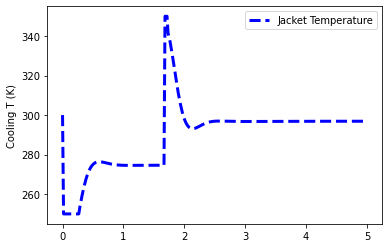

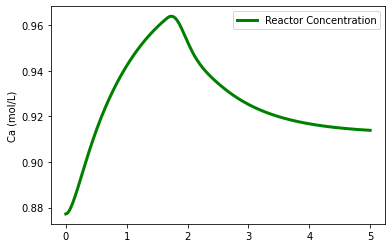

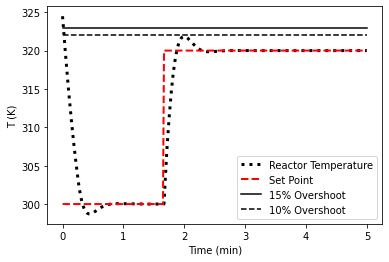

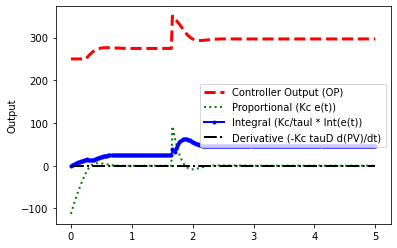

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# from IMC tuning
Kc = 4.61730615181 * 1.0
tauI = 0.913444964569 / 8.0
tauD = 0.0

# define CSTR model
def cstr(x,t,u,Tf,Caf):
    # Inputs (3):
    # Temperature of cooling jacket (K)
    Tc = u
    # Tf = Feed Temperature (K)
    # Caf = Feed Concentration (mol/m^3)

    # States (2):
    # Concentration of A in CSTR (mol/m^3)
    Ca = x[0]
    # Temperature in CSTR (K)
    T = x[1]

    # Parameters:
    # Volumetric Flowrate (m^3/sec)
    q = 100
    # Volume of CSTR (m^3)
    V = 100
    # Density of A-B Mixture (kg/m^3)
    rho = 1000
    # Heat capacity of A-B Mixture (J/kg-K)
    Cp = 0.239
    # Heat of reaction for A->B (J/mol)
    mdelH = 5e4
    # E - Activation energy in the Arrhenius Equation (J/mol)
    # R - Universal Gas Constant = 8.31451 J/mol-K
    EoverR = 8750
    # Pre-exponential factor (1/sec)
    k0 = 7.2e10
    # U - Overall Heat Transfer Coefficient (W/m^2-K)
    # A - Area - this value is specific for the U calculation (m^2)
    UA = 5e4
    # reaction rate
    rA = k0*np.exp(-EoverR/T)*Ca

    # Calculate concentration derivative
    dCadt = q/V*(Caf - Ca) - rA
    # Calculate temperature derivative
    dTdt = q/V*(Tf - T) \
            + mdelH/(rho*Cp)*rA \
            + UA/V/rho/Cp*(Tc-T)
    
    # Return xdot:
    xdot = np.zeros(2)
    xdot[0] = dCadt
    xdot[1] = dTdt
    return xdot

# Steady State Initial Conditions for the States
Ca_ss = 0.87725294608097
T_ss = 324.475443431599
x0 = np.empty(2)
x0[0] = Ca_ss
x0[1] = T_ss

# Steady State Initial Condition
u_ss = 300.0
# Feed Temperature (K)
Tf = 350
# Feed Concentration (mol/m^3)
Caf = 1

# Time Interval (min)
t = np.linspace(0,5,301)

# Store results for plotting
Ca = np.ones(len(t)) * Ca_ss
T = np.ones(len(t)) * T_ss
u = np.ones(len(t)) * u_ss


# storage for recording values
op = np.ones(len(t))*u_ss  # controller output
pv = np.zeros(len(t))  # process variable
e = np.zeros(len(t))   # error
ie = np.zeros(len(t))  # integral of the error
dpv = np.zeros(len(t)) # derivative of the pv
P = np.zeros(len(t))   # proportional
I = np.zeros(len(t))   # integral
D = np.zeros(len(t))   # derivative
sp = np.zeros(len(t))  # set point
sp[0:100] = 300.0
sp[100:] = 320.0

# Upper and Lower limits on OP
op_hi = 350.0
op_lo = 250.0

pv[0] = T_ss
# loop through time steps    
for i in range(len(t)-1):
    delta_t = t[i+1]-t[i]
    e[i] = sp[i] - pv[i]
    if i >= 1:  # calculate starting on second cycle
        dpv[i] = (pv[i]-pv[i-1])/delta_t
        ie[i] = ie[i-1] + e[i] * delta_t
    P[i] = Kc * e[i]
    I[i] = Kc/tauI * ie[i]
    D[i] = - Kc * tauD * dpv[i]
    op[i] = op[0] + P[i] + I[i] + D[i]
    if op[i] > op_hi:  # check upper limit
        op[i] = op_hi
        ie[i] = ie[i] - e[i] * delta_t # anti-reset windup
    if op[i] < op_lo:  # check lower limit
        op[i] = op_lo
        ie[i] = ie[i] - e[i] * delta_t # anti-reset windup
    ts = [t[i],t[i+1]]
    u[i+1] = op[i]
    y = odeint(cstr,x0,ts,args=(u[i+1],Tf,Caf))
    Ca[i+1] = y[-1][0]
    T[i+1] = y[-1][1]
    x0[0] = Ca[i+1]
    x0[1] = T[i+1]
    pv[i+1] = T[i+1]
op[len(t)-1] = op[len(t)-2]
ie[len(t)-1] = ie[len(t)-2]
P[len(t)-1] = P[len(t)-2]
I[len(t)-1] = I[len(t)-2]
D[len(t)-1] = D[len(t)-2]

# Construct results and save data file
# Column 1 = time
# Column 2 = cooling temperature
# Column 3 = reactor temperature
data = np.vstack((t,u,T)) # vertical stack
data = data.T             # transpose data
np.savetxt('data_doublet.txt',data,delimiter=',')
    
# Plot the results
plt.figure(1)
plt.subplot(1,1,1)
plt.plot(t,u,'b--',linewidth=3)
plt.ylabel('Cooling T (K)')
plt.legend(['Jacket Temperature'],loc='best')

plt.figure(2)
plt.subplot(1,1,1)
plt.plot(t,Ca,'g-',linewidth=3)
plt.ylabel('Ca (mol/L)')
plt.legend(['Reactor Concentration'],loc='best')

plt.figure(3)
plt.subplot(1,1,1)
plt.plot(t,T,'k:',linewidth=3,label='Reactor Temperature')
plt.plot(t,sp,'r--',linewidth=2,label='Set Point')
plt.plot([0,max(t)],[320+20*0.15,320+20*0.15],'k-',label='15% Overshoot')
plt.plot([0,max(t)],[320+20*0.1,320+20*0.1],'k--',label='10% Overshoot')
plt.ylabel('T (K)')
plt.xlabel('Time (min)')
plt.legend(loc='best')

plt.figure(4)
plt.subplot(1,1,1)
plt.plot(t,op,'r--',linewidth=3,label='Controller Output (OP)')
plt.plot(t,P,'g:',linewidth=2,label='Proportional (Kc e(t))')
plt.plot(t,I,'b.-',linewidth=2,label='Integral (Kc/tauI * Int(e(t))')
plt.plot(t,D,'k-.',linewidth=2,label='Derivative (-Kc tauD d(PV)/dt)')
plt.legend(loc='center right')
plt.ylabel('Output')

plt.show()
